In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import seaborn as sns
sns.set(color_codes=True)
data = np.load('/Users/lsxliron/Desktop/Fortran_INP-FLUX/Jan2005.npy')

In [17]:
np.std(ps___)

65.480650242184396

In [61]:
fields = ["ps____", "ts____", "al_srf", "em_srf", "mu0___", "tlo3__", "ta____", "t_900_",
              "t_740_", "t_620_", "t_500_", "t_375_", "t_245_", "t_125_", "t_050_", "t_015_", 
              "w900fl", "w740fl", "w620fl", "w500fl", "w375fl", "w245fl", "w125fl", "w050fl", 
              "w015fl", "ntltyp", "cftp01", "cftp02", "cftp03", "cftp04", "cftp05", "cftp06",
              "cftp07", "cftp08", "cftp09", "cftp10", "cftp11", "cftp12", "cftp13", "cftp14",
              "cftp15"]

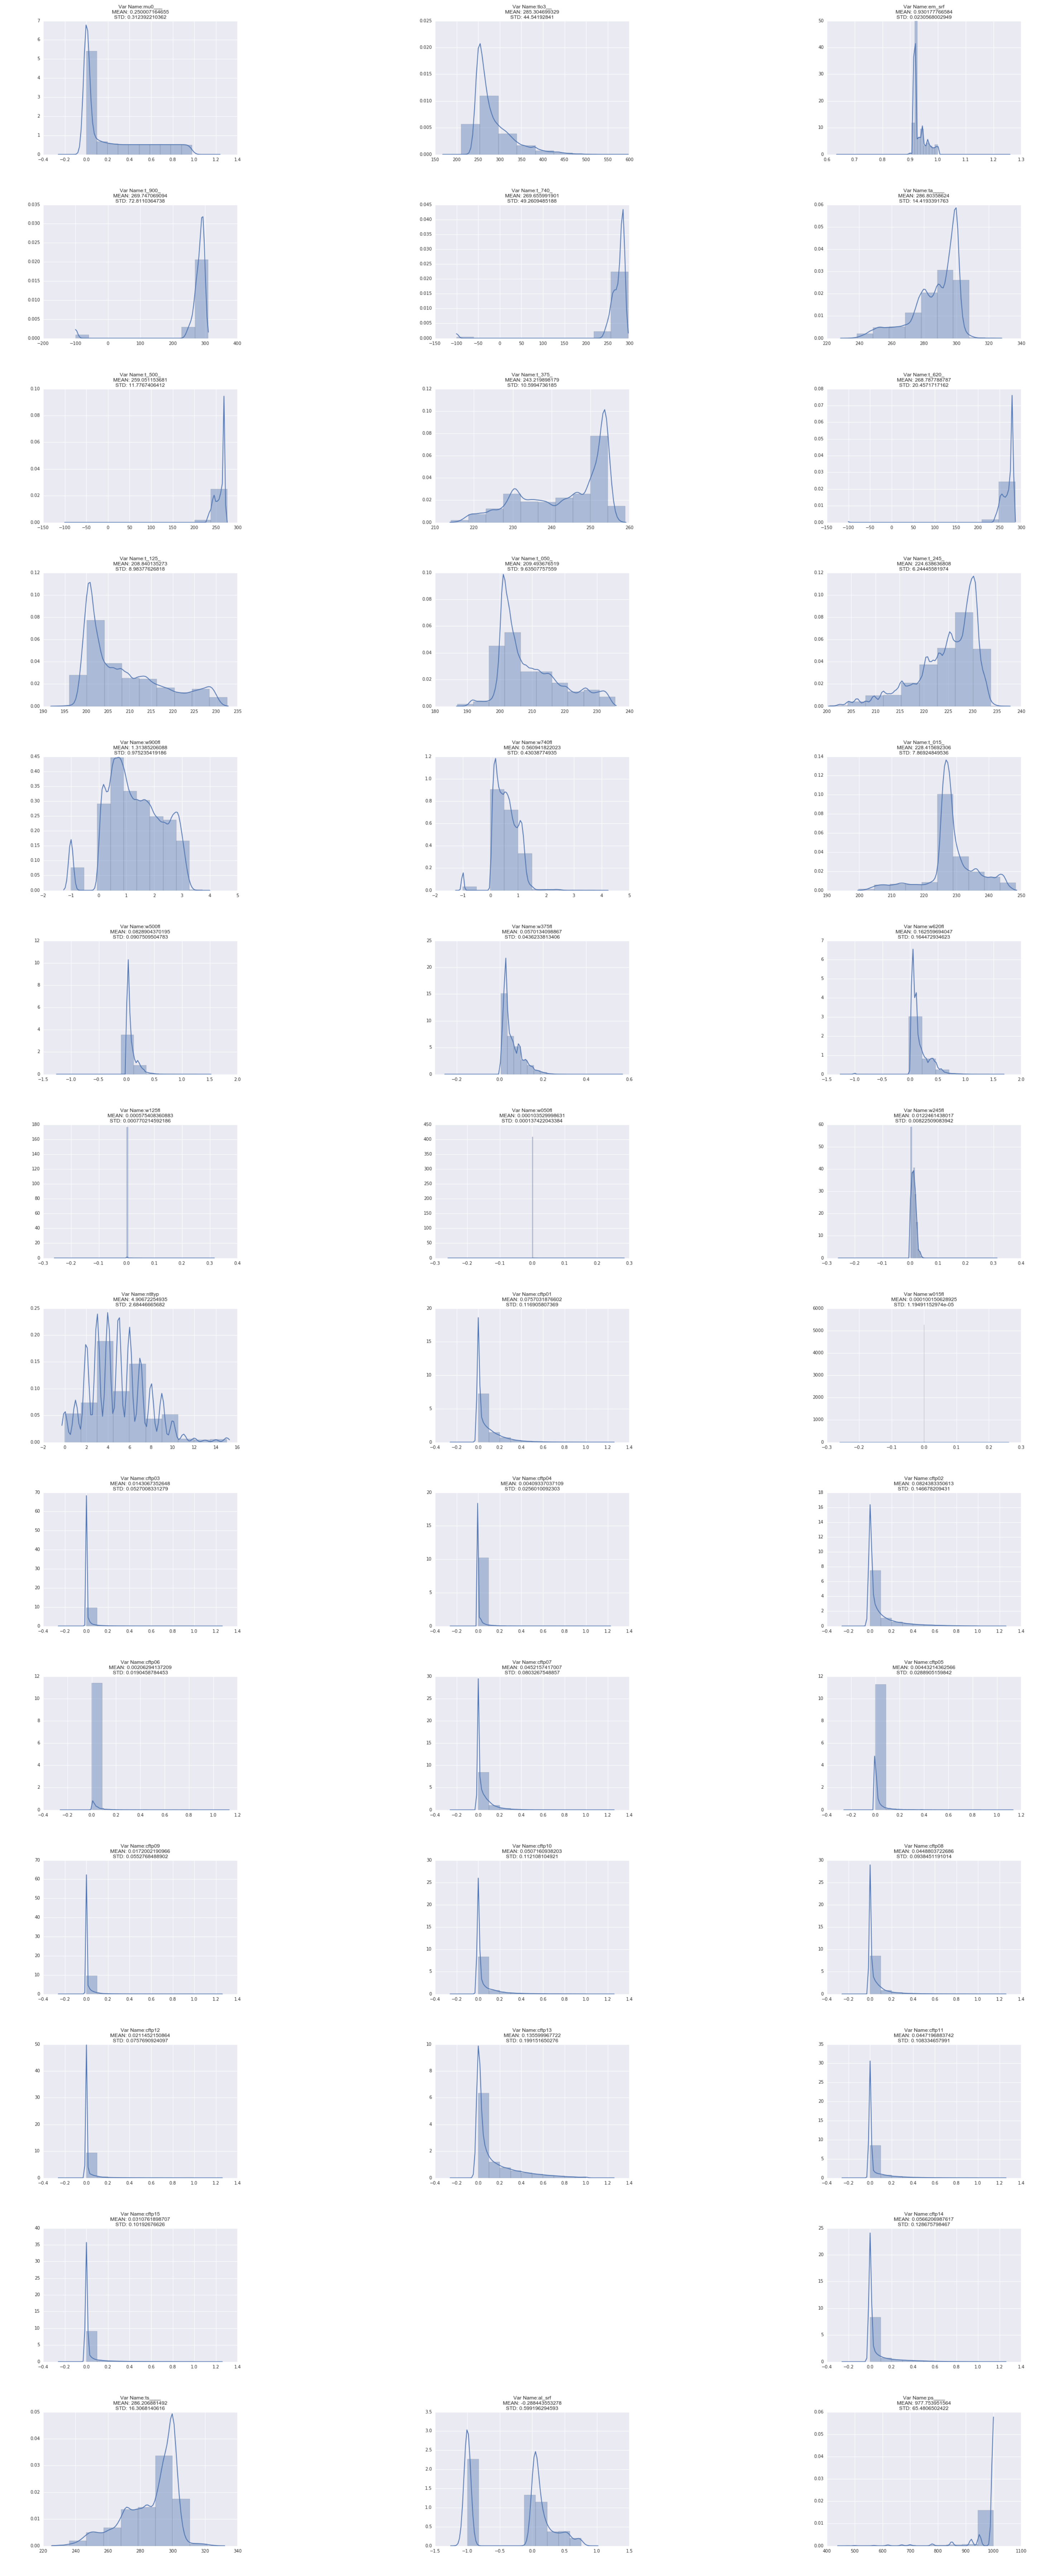

In [190]:
# for i in xrange(0,41):
#     X = data[:,i]
#     stdd = np.std(X)
#     mn = np.mean(X)
#     (sns.distplot(X, bins=10)).set_title("Var Name:{}\nMEAN: {}\nSTD: {}".format(fields[i], mn, stdd))
    
#     plt.savefig("f{}.png".format(i))
#     plt.close()
# plt.show()

fig, ax = plt.subplots(nrows=14, ncols=3, figsize=(50,100))
for a in range(0,14): 
    for b in range(0,3):
#         if (a*3+b)<41:
        ax[a-1][b-1].imshow(plt.imread('f{}.png'.format(a*3+b))); 
        ax[a-1][b-1].axis('off')
    
plt.tight_layout(); 
plt.show()
# Combine them with imshows
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
# for a in [1,2,3]: ax[a-1].imshow(plt.imread('/tmp/f%s.png' %a)); ax[a-1].axis('off')
# plt.tight_layout(); plt.savefig(fig_outfile,bbox_inches='tight'); plt.close() # dpi = 200

# Display in notebook as an image
# Image(fig_outfile, width="100%")

# Generate Blobs

In [270]:
import numpy as np
from sklearn.datasets import make_blobs
import random
n_samples = 5000
n_features = 2
dims = 41

cstd=0.4

centers = list()
for i in range(0,6):
    centers.append([random.randint(-1,1) for x in range(dims)])

    
X, labels_true = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, cluster_std=cstd)
# X = StandardScaler().fit_transform(X)

# Manipulate Data to Have Same STD and Mean

In [271]:
import numpy as np
import bcolz as bc
# Generate 2 matrices (x1 fake, x2 real)
# x1 = np.random.randint(-10, 10, size=(1000,800))
# x2 = np.random.randint(-10, 10, size=(1000,800))
x1, labels_true = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, cluster_std=cstd)
# x2 = np.load('/Users/lsxliron/Desktop/Fortran_INP-FLUX/Jan2005.npy')
x2 = bc.open('/Users/lsxliron/Desktop/Fortran_INP-FLUX/y2005R/', 'r')


# means of data
m1 = x1.mean(axis=0)

# If using NumPy
# m2 = x2.mean(axis=0)

# If using Bcolz
m2 = np.mean(x2, axis=0)

# force fake data to have 0 mean
x1 = x1 - m1



# Covariance matrixes
sigma1 = np.cov(x1.T)

# If using NumPy
# sigma2 = np.cov(x2.T)

# If using Bcolz
sigma2 = np.cov(np.transpose(x2))

sigma1_sqr = np.zeros_like(sigma1)
sigma2_sqr = np.zeros_like(sigma2)


u1,s1,v1 = np.linalg.svd(sigma1)
u2,s2,v2 = np.linalg.svd(sigma2)


threshold = 10e-14

# Zero the eigenvalues that are less than the threshold
non_zero_inde = (s1>threshold).nonzero()
sd1 = np.zeros_like(s1)
sd1[non_zero_inde] = s1[non_zero_inde]**(-.5)

z1 = np.dot(u1, np.dot(np.diag(sd1), np.dot(v1, x1.T))).T

#Now our data has covariance of sigma2
x1_tilde = np.dot(u2, np.dot(np.diag(np.sqrt(s2)),np.dot(np.diag(sd1), np.dot(v1, x1.T)))).T


# Add the mean of X2
x1_star = x1_tilde + m2



In [277]:
print x1_star.mean(), np.mean(x2), x1_star.std(), np.std(x2)

98.5448098824 98.5448098823 182.209713552 182.209910497


In [278]:
X=x1_star

# Dimensionality Reduction

In [279]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
z = model.fit_transform(X)

# Plot with True Labels

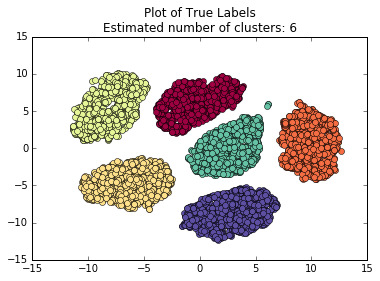

In [280]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = labels_true
core_samples_mask = np.zeros_like(labels_true, dtype=bool)
core_sample_indices = np.arange(n_samples)
core_samples_mask[core_sample_indices] = True
# labels = db.labels_



# Black removed and is used for noise instead.
unique_labels = set(labels_true)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = z[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

    xy = z[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Plot of True Labels\nEstimated number of clusters: %d' % len(set(labels_true)))
# plt.xlim([-15,15])
# plt.ylim([-15,15])
plt.show()

# Plot with Original DBSCAN

CPU times: user 716 ms, sys: 8.48 ms, total: 725 ms
Wall time: 731 ms
NOISE: 61


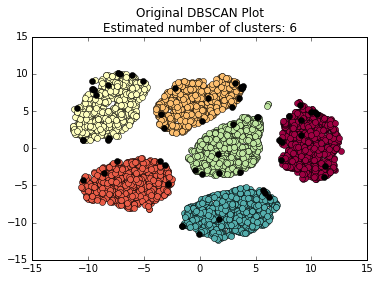

In [281]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt


# Compute DBSCAN
%time db = DBSCAN(eps=21, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Plot result


# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = z[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

    xy = z[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)
# plt.plot(z[:,0], z[:,1], 'o')
n_clusters_ = len(set(db.labels_))-1
print "NOISE: {}".format(db.labels_.tolist().count(-1))
plt.title('Original DBSCAN Plot\nEstimated number of clusters: %d' % n_clusters_)
plt.show()

# Plot with DBSCAN and ANNOY

CPU times: user 596 ms, sys: 6.72 ms, total: 603 ms
Wall time: 631 ms
Done
Clustering
CPU times: user 23.3 ms, sys: 2.21 ms, total: 25.5 ms
Wall time: 42.8 ms
Finished
unique labels: set([0, 1, 2, 3, 4, 5, -1])
NOISE: 68


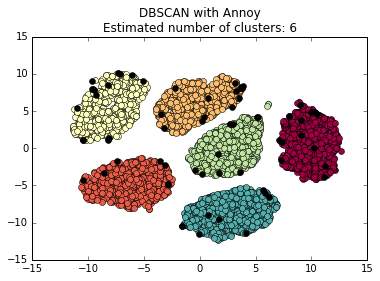

In [282]:
from annoy import AnnoyIndex
from sklearn.cluster import DBSCAN
t = None
t = AnnoyIndex(dims, metric="euclidean")
for i in xrange(0,len(X)):
    t.add_item(i, X[i])

t.build(25)
n_neighbors = 40 #20 for 1000 points
r= 21 #19 for 1000 points
# tempnns = [np.array(t.get_nns_by_item(i, n_neighbors), dtype=np.int64) for i in xrange(0,len(X))]
%time tempnns = [np.array([j[0] for j in zip(*(t.get_nns_by_item(i,n_neighbors,include_distances=True))) if j[1]<r],dtype=np.int64) for i in xrange(0,len(X))]
tempnns[len(tempnns)-1] = tempnns[len(tempnns)-1][:-1]
neighborhoods = np.array(tempnns, dtype=object)

model = {'neighborhoods':neighborhoods}

print "Done\nClustering"
%time db = DBSCAN(eps=0.000001, min_samples=10, algorithm="LSH", lshModel=model).fit(X)
print "Finished"
print "unique labels: {}".format(set(db.labels_))
print "NOISE: {}".format(db.labels_.tolist().count(-1))
labels = db.labels_
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = z[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

    xy = z[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

n_clusters_ = len(set(db.labels_))-1
plt.title('DBSCAN with Annoy\nEstimated number of clusters: %d' % n_clusters_)
plt.show()


# Bechmarks
## NearPy

In [267]:
import numpy

from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections
from nearpy.filters import NearestFilter
from nearpy.distances import EuclideanDistance

# Dimension of our vector space
dimension = 41
n_neighbors = 10
# Create a random binary hash with 10 bits
rbp = RandomBinaryProjections('rbp', 25)

# Create engine with pipeline configuration
engine = Engine(dimension, lshashes=[rbp], distance=EuclideanDistance(), vector_filters=[NearestFilter(n_neighbors)])

# Index 1000000 random vectors (set their data to a unique string)
for i in xrange(len(X)):
    engine.store_vector(X[i],str(i))
# Create random query vector
# query = numpy.random.randn(dimension)

# Get nearest neighbours
N = engine.neighbours(X[0])
r=20

In [217]:
%time xxxx=[np.array([int(j[1]) for j in zip(*(zip(*(engine.neighbours(X[i]))))) if j[2]<r], dtype=np.int64) for i in range(0,len(X))]

CPU times: user 37.6 s, sys: 108 ms, total: 37.8 s
Wall time: 38.2 s


# LSHash

In [267]:
from lshash import LSHash

lsh = LSHash(25, 41, num_hashtables=10)

for i in xrange(len(X)):
    lsh.index(X[i], extra_data=str(i))
    
r=20
n_neighbors=10
q = lsh.query(X[0], num_results=n_neighbors, distance_func="euclidean")

In [239]:
print q[2][0][1]

1270


In [275]:
%time xxxx = [np.array([int(j[0][1]) for j in zip(*(zip(*(lsh.query(X[i], num_results=n_neighbors, distance_func="true_euclidean"))))) if j[1]<r], dtype=np.int64) for i in xrange(len(X))]


CPU times: user 4min 56s, sys: 2.05 s, total: 4min 58s
Wall time: 5min 10s


# Using FALCONN

In [3]:
import falconn
import bcolz as bc
import numpy as np
dataset = np.load('/Users/lsxliron/Desktop/Fortran_INP-FLUX/Jan2005.npy')[0:20000]
params = falconn.LSHConstructionParameters()
params.dimension = 41
params.lsh_family = 'cross_polytope'
params.distance_function = 'euclidean_squared'
params.l = 10
params.num_rotations = 1
params.num_setup_threads = 0
params.storage_hash_table = 'bit_packed_flat_hash_table'
falconn.compute_number_of_hash_functions(25, params)
table = falconn.LSHIndex(params)
table.setup(dataset)


In [362]:
r=600
%time tempnns = [np.array(table.find_near_neighbors(dataset[i], r), dtype=np.int64) for i in xrange(5000)]



CPU times: user 14.2 s, sys: 329 ms, total: 14.5 s
Wall time: 15.9 s


In [ ]:
tempnns[len(tempnns)-1] = tempnns[len(tempnns)-1][:-1]

In [ ]:
neighborhoods = np.array(tempnns, dtype=object)

Done
Clustering
100 loops, best of 3: 9.3 ms per loop
Finished
unique labels: set([0, 1, 2, 3, 4, 5, -1])
NOISE: 84


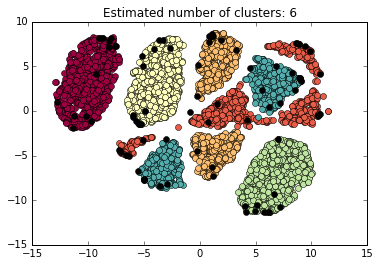

In [307]:
%matplotlib inline
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt

model = {'neighborhoods':neighborhoods}

print "Done\nClustering"
%timeit db = DBSCAN(eps=0.000001, min_samples=10, algorithm="LSH", lshModel=model).fit(X)
print "Finished"
print "unique labels: {}".format(set(db.labels_))
print "NOISE: {}".format(db.labels_.tolist().count(-1))
labels = db.labels_
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = z[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

    xy = z[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

n_clusters_ = len(set(db.labels_))-1
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()



# Annoy

In [363]:
from annoy import AnnoyIndex
from sklearn.cluster import DBSCAN
t = None
t = AnnoyIndex(dims, metric="euclidean")
for i in xrange(0,len(X)):
    t.add_item(i, dataset[i])

t.build(25)
n_neighbors = 200
r=600

%time tempnns = [np.array([j[0] for j in zip(*(t.get_nns_by_item(i,n_neighbors,include_distances=True))) if j[1]<r],dtype=np.int64) for i in xrange(5000)]
tempnns[len(tempnns)-1] = tempnns[len(tempnns)-1][:-1]
neighborhoods = np.array(tempnns, dtype=object)


CPU times: user 1.66 s, sys: 18.2 ms, total: 1.68 s
Wall time: 1.68 s


# LSHF

In [351]:
from sklearn.neighbors import LSHForest

n_neighbors=20
lshf = LSHForest(n_candidates=50, radius=0.00160577)
lshf.fit(dataset)
print "LSHF index build time: "


LSHF index build time: 


In [352]:
q = lshf.kneighbors(X[0].reshape(-1,41),return_distance=True)

In [353]:
for j in zip(*(lshf.kneighbors(X[0].reshape(-1,41),return_distance=True))):
    print j

(array([ 0.00154522,  0.00159857,  0.00160577,  0.00161704,  0.00162055]), array([18163,  5319, 11938,  4949,  6481]))


In [361]:
%time [np.array(lshf.kneighbors(X[i].reshape(-1,41),return_distance=False), dtype=np.int64) for i in xrange(5000)]

CPU times: user 1min 50s, sys: 15.4 s, total: 2min 6s
Wall time: 2min 9s


[array([[18163,  5319, 11938,  4949,  6481]]),
 array([[ 8644, 11198,  9090, 11125,  4331]]),
 array([[18536,  5570, 12406,  5462, 13089]]),
 array([[ 9304,  2850, 11632,  2995,  4304]]),
 array([[12533,   258,  6797, 12152, 12876]]),
 array([[11198,  4587,  4466, 17794, 10889]]),
 array([[11822, 18507, 11459, 18152, 13159]]),
 array([[ 5626,  5523,  5627,  5522, 18191]]),
 array([[12406, 12309, 12138, 12310, 18839]]),
 array([[3984, 4124, 5626, 4895, 4121]]),
 array([[18163, 11884, 19476, 11998, 19541]]),
 array([[ 9090, 15146,  3484, 15147, 16104]]),
 array([[12533, 12152, 18527, 12876,  6215]]),
 array([[ 4587,  4167,  9090, 10774, 17817]]),
 array([[ 4469, 10931, 17938,  1138,  4470]]),
 array([[ 5463,  7036, 13869,   374,  7035]]),
 array([[18163,  6481, 11805, 18401, 12032]]),
 array([[ 4304, 15239,  9304, 15073,  2850]]),
 array([[19269, 19268,  4895,  3839,  4124]]),
 array([[17659, 17522, 10931,  4331,  4469]]),
 array([[15146, 10640, 10641, 15147,  3484]]),
 array([[18163,  5

# Plain NN

In [38]:
from sklearn.neighbors import BallTree
from sklearn.metrics import euclidean_distances
import warnings
warnings.filterwarnings('ignore')
tree = BallTree(dataset[0:5000], metric=euclidean_distances)


In [39]:
%time xxx = tree.query_radius(dataset[0:1000], r=20)

CPU times: user 1min 33s, sys: 524 ms, total: 1min 33s
Wall time: 1min 35s


# Benchmarks

- Dataset size: [10, 100, 1000, 5000, 10000, 50000, 10000 |(annoy) 200000] 
- **Objective** - find the 10 neighbors of each data point in the data set

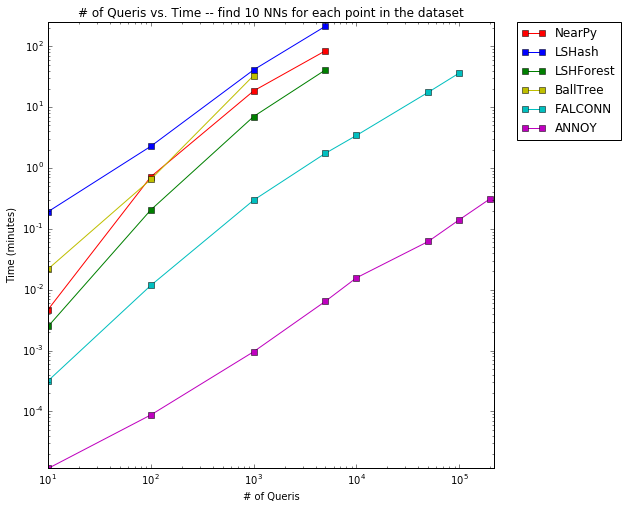

In [232]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
nn1 = [10, 100, 1000, 5000]
nn2 = [10, 100, 1000]
nn3 = [10, 100, 1000, 5000, 10000, 50000, 100000]
nn4 = [10, 100, 1000, 5000, 10000, 50000, 100000, 200000]
NearPy = np.array([0.282789945602, 43.055464983, 1109.43007493, 5068.18352485])/60
LSHash = np.array([11.4800400734, 136.558726788, 2460.09930182, 12828.4408081])/60
LSHF = np.array([0.149438142776, 12.3038740158, 420.95878315, 2457.82441092])/60
BallTree = np.array([1.31133818626, 38.97853899, 1986.48432899])/60
FALCONN = np.array([0.0190908908844, 0.706834793091, 17.7695150375, 104.885365009, 205.73413682, 1054.47827888, 2179.33671188])/60
ANNOY = np.array([0.000694036483765, 0.00526213645935, 0.0575098991394, 0.388188123703, 0.941348075867, 3.72867012024, 8.45559310913, 18.7639729977])/60


plt.xlabel("# of Queris")
plt.ylabel("Time (minutes)")
plt.title("# of Queris vs. Time -- find 10 NNs for each point in the dataset")
plt.loglog(nn1, NearPy, 'rs-', label="NearPy")
plt.loglog(nn1, LSHash, 'bs-', label="LSHash")
plt.loglog(nn1, LSHF, 'gs-', label="LSHForest")
plt.loglog(nn2, BallTree, 'ys-', label="BallTree")
plt.loglog(nn3, FALCONN, 'cs-', label="FALCONN")
plt.loglog(nn4, ANNOY, 'ms-', label="ANNOY")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim(-2000,220000);
plt.ylim(-2,250);

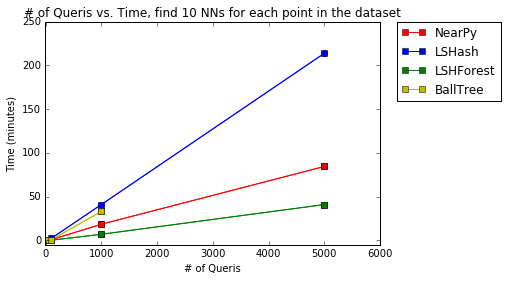

In [233]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.figure(figsize=(8,8))

nn1 = [10, 100, 1000, 5000]
nn2 = [10, 100, 1000]
nn3 = [10, 100, 1000, 5000, 10000, 50000, 100000]
nn4 = [10, 100, 1000, 5000, 10000, 50000, 100000, 200000]
NearPy = np.array([0.282789945602, 43.055464983, 1109.43007493, 5068.18352485])/60
LSHash = np.array([11.4800400734, 136.558726788, 2460.09930182, 12828.4408081])/60
LSHF = np.array([0.149438142776, 12.3038740158, 420.95878315, 2457.82441092])/60
BallTree = np.array([1.31133818626, 38.97853899, 1986.48432899])/60
FALCONN = np.array([0.0190908908844, 0.706834793091, 17.7695150375, 104.885365009, 205.73413682, 1054.47827888, 2179.33671188])/60
ANNOY = np.array([0.000694036483765, 0.00526213645935, 0.0575098991394, 0.388188123703, 0.941348075867, 3.72867012024, 8.45559310913, 18.7639729977])/60

plt.plot(nn1, NearPy, 'rs-', nn1, LSHash, 'bo-', nn1, LSHF, 'gs-', nn2, BallTree, 'ys-')

plt.xlabel("# of Queris")
plt.ylabel("Time (minutes)")
plt.title("# of Queris vs. Time, find 10 NNs for each point in the dataset")
plt.plot(nn1, NearPy, 'rs-', label="NearPy")
plt.plot(nn1, LSHash, 'bs-', label="LSHash")
plt.plot(nn1, LSHF, 'gs-', label="LSHForest")
plt.plot(nn2, BallTree, 'ys-', label="BallTree")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(-5,6000);
plt.ylim(-5,250);

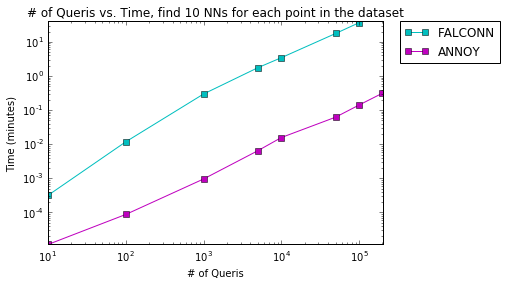

In [234]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.figure(figsize=(8,8))

nn3 = [10, 100, 1000, 5000, 10000, 50000, 100000]
nn4 = [10, 100, 1000, 5000, 10000, 50000, 100000, 200000]
FALCONN = np.array([0.0190908908844, 0.706834793091, 17.7695150375, 104.885365009, 205.73413682, 1054.47827888, 2179.33671188])/60
ANNOY = np.array([0.000694036483765, 0.00526213645935, 0.0575098991394, 0.388188123703, 0.941348075867, 3.72867012024, 8.45559310913, 18.7639729977])/60

plt.xlabel("# of Queris")
plt.ylabel("Time (minutes)")
plt.title("# of Queris vs. Time, find 10 NNs for each point in the dataset")
plt.loglog(nn3, FALCONN, 'cs-', label="FALCONN")
plt.loglog(nn4, ANNOY, 'ms-', label="ANNOY")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(-50,202000);
plt.ylim(-2,40);

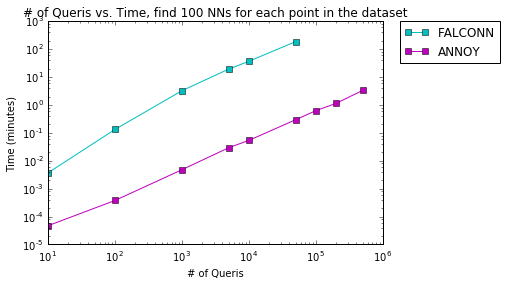

In [283]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.figure(figsize=(8,8))

nn3 = [10, 100, 1000, 5000, 10000, 50000]
nn4 = [10, 100, 1000, 5000, 10000, 50000, 100000, 200000, 500000]
FALCONN = np.array([0.22172999382, 7.96406388283, 194.779117107, 1159.07759809, 2211.23744702, 11223.2789822], dtype=np.float64)/60
ANNOY = np.array([0.00282502174377, 0.0226531028748, 0.286737918854, 1.76185297966, 3.23346590996, 17.8030719757, 37.563762188, 68.27196908, 199.739862919])/60

plt.xlabel("# of Queris")
plt.ylabel("Time (minutes)")
plt.title("# of Queris vs. Time, find 100 NNs for each point in the dataset")
plt.loglog(nn3, FALCONN, 'cs-', label="FALCONN")
plt.loglog(nn4, ANNOY, 'ms-', label="ANNOY")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

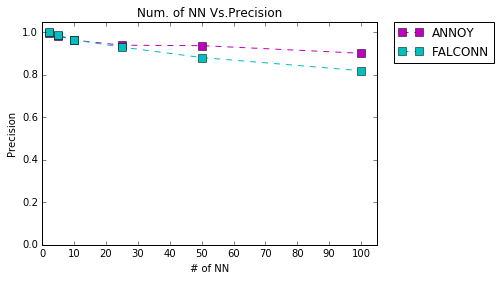

In [236]:
annoyGrades = np.array([995, 983, 963, 939, 937, 901], dtype=np.float64)/1000
falconnGrades = np.array([999, 987, 964, 930, 881, 819], dtype=np.float64)/1000
nn = [2,5,10,25,50,100]
plt.xlabel("# of NN")
plt.ylabel("Precision")
plt.title("Num. of NN Vs.Precision")
plt.ylim(0,1.05)
plt.xlim(0,105)
plt.locator_params(axis='x',nbins=20)
plt.plot(nn, annoyGrades, 'ms--', markersize=8, label="ANNOY")
plt.plot(nn, falconnGrades, 'cs--', markersize=8, label="FALCONN")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Queries for 10 NNs, Dataset size: 200K (time in seconds)

|  Algorithm  |   10   |  100   |  1000  |  5,000   | 10,000 | 50,000  | 100,000 | 200,000 |
|:-----------:|:------:|:------:|:------:|:--------:|:------:|:-------:|:-------:|:-------:|
|**BallTree** | 1.311  | 18.978 |1986.484|     X    |    X   |    X    |    X    |    X    |
|**NearPy**   | 0.283  | 43.055 | 1109.43|5608.184  |    X   |    X    |    X    |    X    |
|**LSHash**   | 11.48  | 136.559|2460.099|12828.441 |    X   |    X    |    X    |    X    |
|**LSHForest**| 0.149  | 12.304 |420.959 |2457.824  |    X   |    X    |    X    |    X    |
|**FLACONN**  | 0.02   | 0.707  | 17.77  | 104.885  | 205.734| 1054.478|2179.337 |    X    |
|**Annoy**    | 0.0007 |0.005   | 0.058  | 0.388    | 0.941  | 3.729   | 8.455   | 18.764  |

## Queries for 100 NNs, Dataset size: 2.4M (time in seconds)

| Algorithm |   10   |  100   |  1000  |  5,000   | 10,000  | 50,000  | 100,000 | 200,000 | 500,000|
|:---------:|:------:|:------:|:------:|:--------:|:-------:|:-------:|:-------:|:-------:|:------:|
|**FLACONN**| 0.222  | 7.965  | 194.779| 1159.078 | 2211.237|11223.279|    X    |    X    |   X    |
|**Annoy**  | 0.002  | 0.023  | 0.287  | 1.762    | 3.233   | 17.803  | 37.564  | 68.272  | 199.740|
